<a href="https://colab.research.google.com/github/Sarasswati/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
import warnings
import missingno as msno
warnings.filterwarnings('ignore')

from numpy import math
from haversine import haversine
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
working_directory = '/content/drive/MyDrive/Colab Notebooks/Capstone Project 2/'
taxi_df = pd.read_csv(working_directory + 'NYC Taxi Data.csv', encoding= 'unicode_escape')

In [ ]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
taxi_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
taxi_df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

In [ ]:
taxi_df.duplicated().sum()

0

### There is no duplicate value.

In [ ]:
taxi_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### There is no null value.

In [ ]:
taxi_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [ ]:
taxi_df[taxi_df['passenger_count']==0].count()

id                    60
vendor_id             60
pickup_datetime       60
dropoff_datetime      60
passenger_count       60
pickup_longitude      60
pickup_latitude       60
dropoff_longitude     60
dropoff_latitude      60
store_and_fwd_flag    60
trip_duration         60
dtype: int64

In [ ]:
taxi_df = taxi_df[taxi_df['passenger_count']!=0]

## Feature Engineering

There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features. As we can only feed numeric features as input to our models, our next task is to convert the features in numeric form. Feature engineering is the process of extracting information from the existing data in order to improve the performance of the model. Feature engineering is subdivided into two parts: Feature preprocessing & Feature generation

In [ ]:
# Convert string date to datetime features.
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df.pickup_datetime)
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df.pickup_datetime)

One hot encoding is for nominal values and label encoding for ordinal values which have inherent order within them, to prevent the loss of information from them. One hot encoder does not preserve the order of the information. The order information will be lost while working with One hot encoder on ordinal variables The limitation with label encoding is that it prioritizes the classes based on the labels provided by it. This might convey unnecessary information to the model that the class with label 2 is superior to the class with label 1. In 'store_and_fwd_flag', only two values are present either 'Y' or 'N'. So it is better to replace Y with 1 and N with zero.

In [ ]:
taxi_df['store_and_fwd_flag'] = taxi_df['store_and_fwd_flag'].replace({'Y' : 1, 'N' : 0})

#### Haversine Distance

To calculate the distance (km) between pickup and dropoff points. Difference between pickup and dropoff points will give an idea about the distances covered which should be the most predictive feature for taxi fare. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

The haversine formula approximates the great-circle distance between two points on a sphere given their longitudes, latitudes and the sphere’s radius. The sphere we are interested in here is the Earth – which is not a perfect sphere, but close enough for the approximations that we are interested in. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.

Haversine distance can be found using geopy library, scikitlearn library, or by implementing Haversine formula by defining a custom made function. All three methods are described below.

In [ ]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [ ]:
#Calculate distance and assign new column to the dataframe.
taxi_df["distance"] = taxi_df.apply(lambda x: calc_distance(x),axis=1)

In [ ]:
taxi_df.loc[:, 'pickup_hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df.loc[:, 'pickup_weekday'] = taxi_df['pickup_datetime'].dt.day_name()
taxi_df.loc[:, 'pickup_date'] = taxi_df['pickup_datetime'].dt.day
taxi_df.loc[:, 'pickup_month'] = taxi_df['pickup_datetime'].dt.month
taxi_df.loc[:, 'pickup_day'] = taxi_df['pickup_datetime'].dt.dayofweek

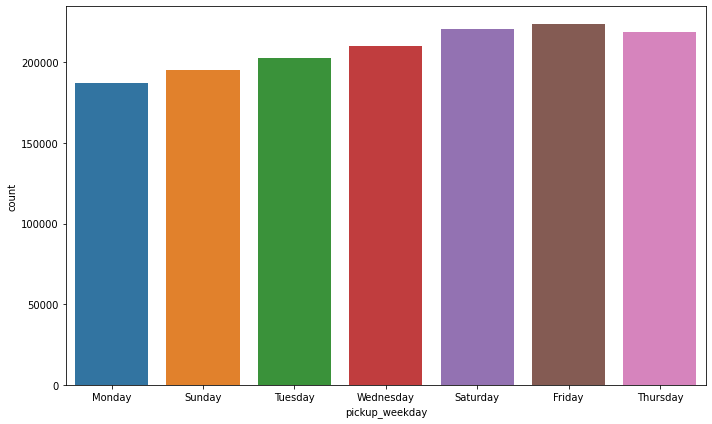

In [ ]:
#Number of Pickups and Dropoff on each day of the week
figure,ax=plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.countplot(x='pickup_weekday', data=taxi_df)

plt.tight_layout()

##### Most trips were taken on Friday and Monday being the least. 

In [ ]:
# Calculating peak hours
def baseFare(x):
    if x in range(16,20):
        Peak_Hour = 2
    elif x in range(20,24):
        Peak_Hour = 1
    else:
        Peak_Hour = 0
    return Peak_Hour

In [ ]:
taxi_df['Peak_Hour'] = taxi_df['pickup_hour'].apply(baseFare)

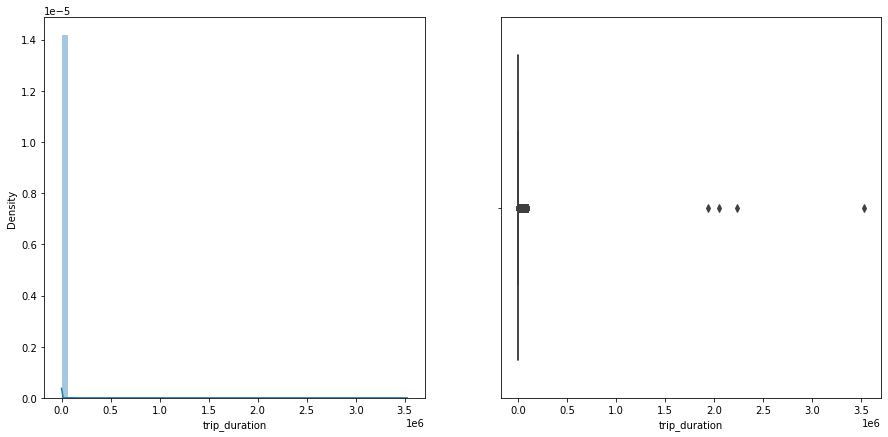

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
sns.distplot(taxi_df['trip_duration'], ax=axes[0])
sns.boxplot(taxi_df['trip_duration'], ax=axes[1])

From the box plot it is clearly visible that there are two trips with duration of around 618.78 hours. This is a huge outlier and might create problems at the prediction stage. One idea is to log transform or square root transform the right skewed trip duration before prediction to visualise it better. Replacing outliers with whisker values is another methods of treating outliers. Values at the lower end should be imputed by the lower whisker (i.e., Q1-1.5 IQR) and the values at the upper end should be imputed by the upper whisker (ie., Q3+1.5IQR).

In [ ]:
percentile_q1_trip_duration = np.percentile(taxi_df['trip_duration'],25)
percentile_q3_trip_duration = np.percentile(taxi_df['trip_duration'],75)
IQR = percentile_q3_trip_duration - percentile_q1_trip_duration
whisker_1 = percentile_q1_trip_duration - (1.5*IQR)
whisker_2 = percentile_q3_trip_duration + (1.5*IQR)

whisker_1, whisker_2
print("lower limit for outlier  :", whisker_1)
print("Upper limit for outlier  :", whisker_2)

lower limit for outlier  : -620.0
Upper limit for outlier  : 2092.0


In [ ]:
taxi_df = taxi_df[taxi_df['trip_duration']>0]
taxi_df = taxi_df[taxi_df['trip_duration']<whisker_2]

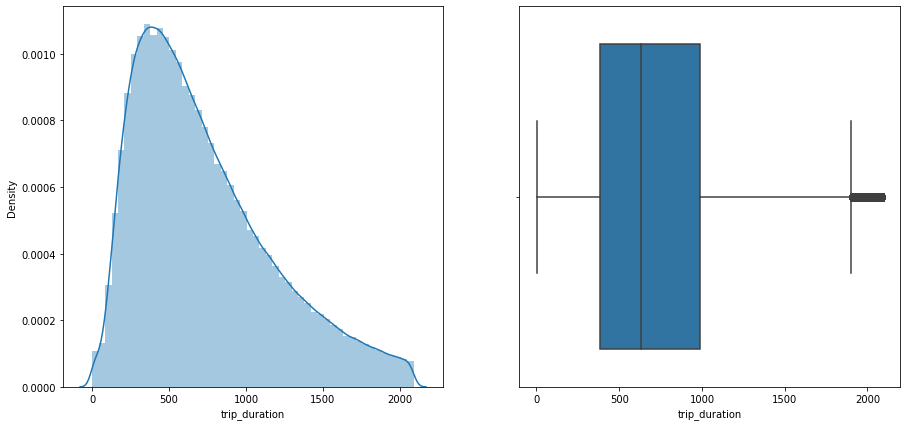

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
sns.distplot(taxi_df['trip_duration'], ax=axes[0])
sns.boxplot(taxi_df['trip_duration'], ax=axes[1])

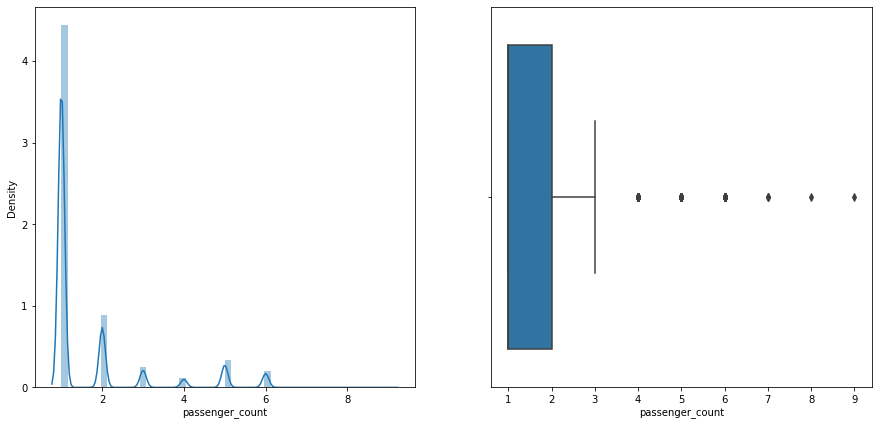

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
sns.distplot(taxi_df['passenger_count'], ax=axes[0])
sns.boxplot(taxi_df['passenger_count'], ax=axes[1])

From the box plot it is clearly visible that there are outliers and might create problems at the prediction stage. One idea is to log transform or square root transform the passenger count before prediction to visualise it better. Replacing outliers with whisker values is another methods of treating outliers. Values at the lower end should be imputed by the lower whisker (i.e., Q1-1.5 IQR) and the values at the upper end should be imputed by the upper whisker (ie., Q3+1.5IQR).


In [ ]:
percentile_q1_passenger_count = np.percentile(taxi_df['passenger_count'],25)
percentile_q3_passenger_count = np.percentile(taxi_df['passenger_count'],75)

IQR3 = percentile_q3_passenger_count - percentile_q1_passenger_count
whisker_31 = percentile_q1_passenger_count - (1.5*IQR3)
whisker_32 = percentile_q3_passenger_count + (1.5*IQR3)

whisker_31, whisker_32
print("lower limit for outlier  :", whisker_31)
print("Upper limit for outlier  :", whisker_32)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [ ]:
taxi_df = taxi_df[taxi_df['passenger_count']>0]
taxi_df = taxi_df[taxi_df['passenger_count']<whisker_32]

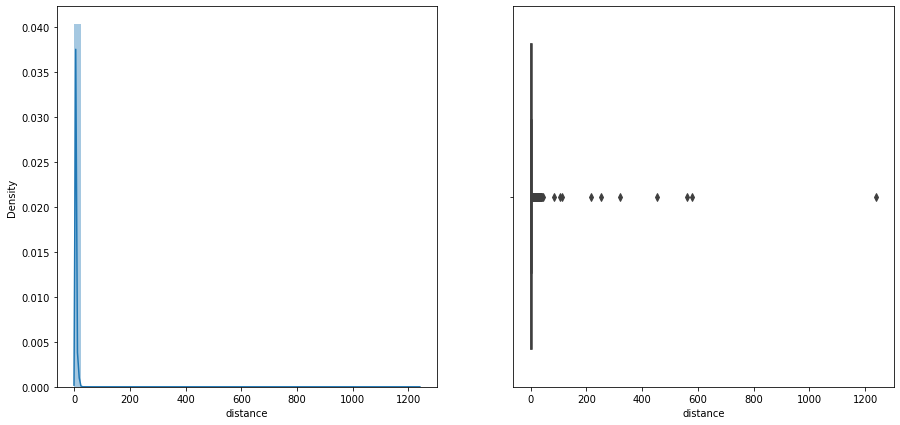

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
sns.distplot(taxi_df['distance'], ax=axes[0])
sns.boxplot(taxi_df['distance'], ax=axes[1])

From the box plot it is clearly visible that there are outliers and might create problems at the prediction stage. One idea is to log transform or square root transform the distance before prediction to visualise it better. Replacing outliers with whisker values is another methods of treating outliers. Values at the lower end should be imputed by the lower whisker (i.e., Q1-1.5 IQR) and the values at the upper end should be imputed by the upper whisker (ie., Q3+1.5IQR).

In [ ]:
percentile_q1 = np.percentile(taxi_df['distance'],25)
percentile_q3 = np.percentile(taxi_df['distance'],75)
IQR2 = percentile_q3 - percentile_q1
whisker_21 = percentile_q1 - (1.5*IQR2)
whisker_22 = percentile_q3 + (1.5*IQR2)

whisker_21, whisker_22
print("lower limit for outlier  :", whisker_21)
print("Upper limit for outlier  :", whisker_22)

lower limit for outlier  : -2.2316082501514933
Upper limit for outlier  : 6.912672636994813


In [ ]:
taxi_df = taxi_df[taxi_df['distance']>whisker_21]
taxi_df = taxi_df[taxi_df['distance']<whisker_22]

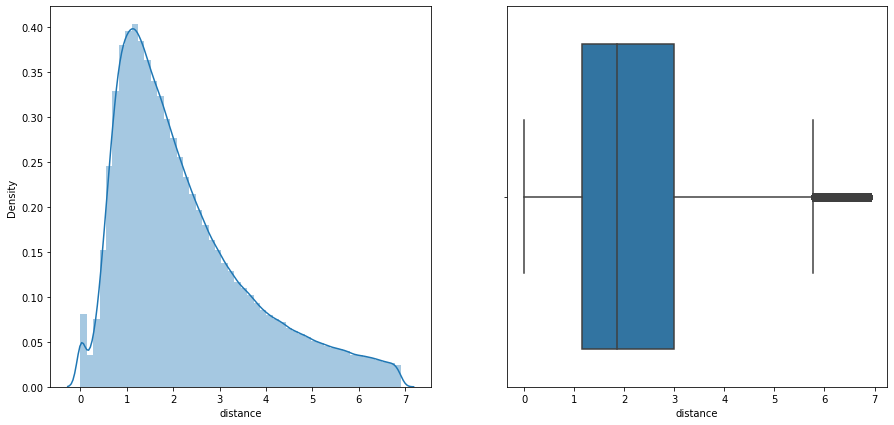

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
sns.distplot(taxi_df['distance'], ax=axes[0])
sns.boxplot(taxi_df['distance'], ax=axes[1])

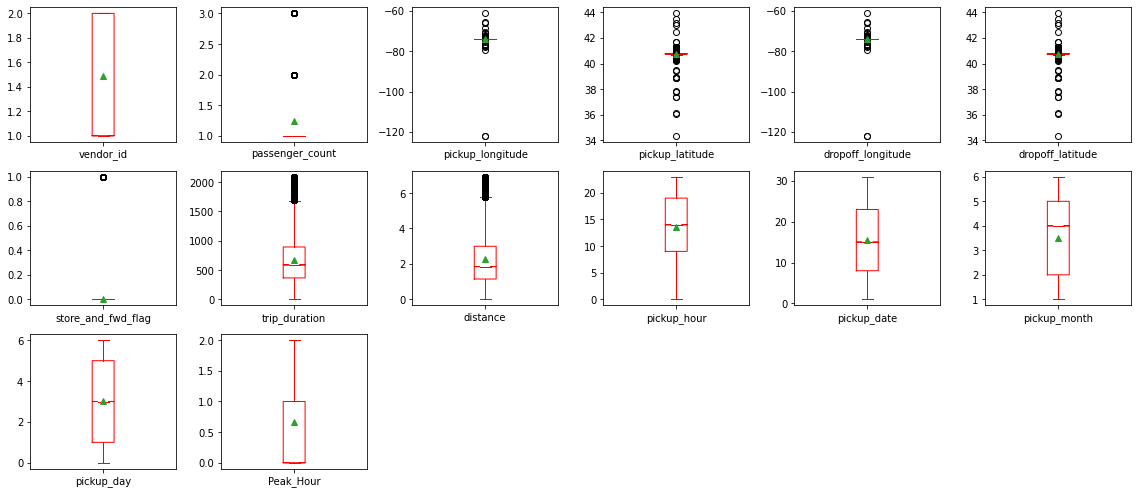

In [ ]:
taxi_df.plot(kind = 'box', subplots = True, notch=True, showmeans=True, layout = (4,6), figsize = (16,9), color = 'red')
plt.tight_layout()

In [ ]:
taxi_df['trip_duration_hour']=taxi_df['trip_duration']/3600
taxi_df['log_distance']=np.log(taxi_df.distance)
taxi_df['log_trip_duration']=np.log(taxi_df.trip_duration_hour)

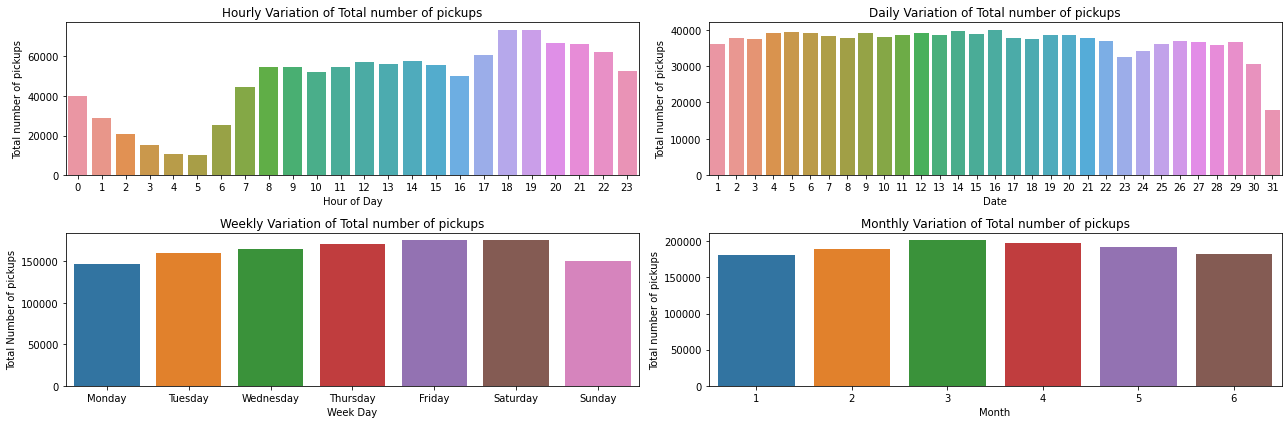

In [ ]:
# Datetime features
plt.figure(figsize=(18, 6))

# Hour of day
plt.subplot(221)
sns.countplot(taxi_df['pickup_hour'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')
plt.title('Hourly Variation of Total number of pickups')

# Date
plt.subplot(222)
sns.countplot(taxi_df['pickup_date'])
plt.xlabel('Date')
plt.ylabel('Total number of pickups')
plt.title('Daily Variation of Total number of pickups')

# Day of week
plt.subplot(223)
sns.countplot(taxi_df['pickup_weekday'], order = ['Monday', 'Tuesday', 'Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')
plt.title('Weekly Variation of Total number of pickups')

# Month
plt.subplot(224)
sns.countplot(taxi_df['pickup_month'])
plt.xlabel('Month')
plt.ylabel('Total number of pickups')
plt.title('Monthly Variation of Total number of pickups')
plt.tight_layout();

In [ ]:
bins=np.array([0,1800,3600,5400,7200,90000])
taxi_df['duration_time']=pd.cut(taxi_df.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [ ]:
import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
taxi_df['pickup_timezone']=taxi_df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
taxi_df['dropoff_timezone']=taxi_df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

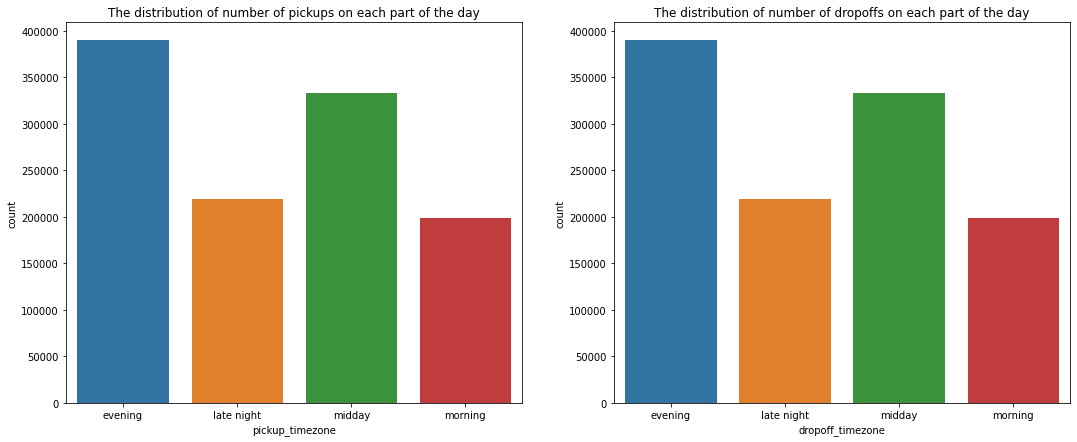

In [ ]:
# Distribution of the number of Pickups and Dropoffs in a day
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(18,7))
sns.countplot(x='pickup_timezone', data=taxi_df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone', data=taxi_df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

### Observations

* Even though, contrary to the expectation, number of pickups is much lower during the morning peak hours, it is highest in late evenings as expected.
* Number of pickups on sundays and mondays are much lower than other days with a peak on Saturday.
* Monthly plot shows significant variation towards the end of the month.
* Annual variation visible with March - April showing maximum number of trips compared to the other 4 months.

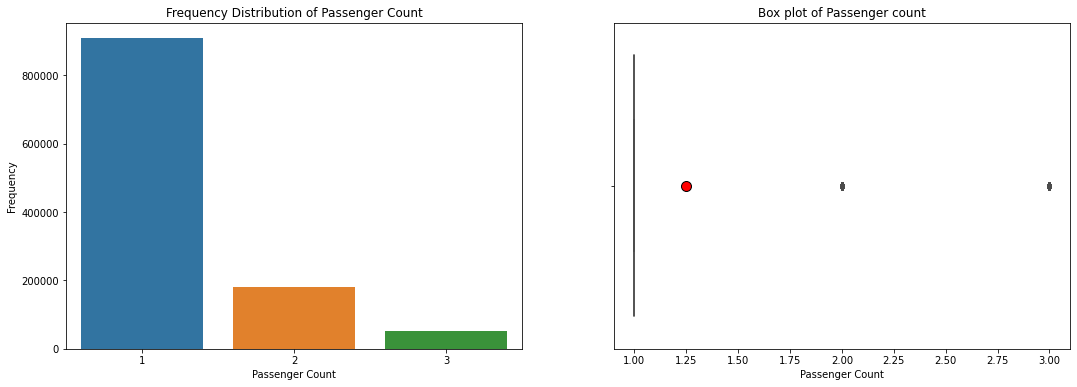

In [ ]:
plt.figure(figsize=(18, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(121)
sns.countplot(taxi_df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Passenger Count')

#Box plot of passenger count
plt.subplot(122)
sns.boxplot(taxi_df['passenger_count'], color = 'cyan', showmeans=True, meanprops={"marker":"o", "markerfacecolor":"Red", "markeredgecolor":"black","markersize":"10"})
plt.xlabel('Passenger Count')
plt.title('Box plot of Passenger count');

Most of the trips involve only 1 passenger.

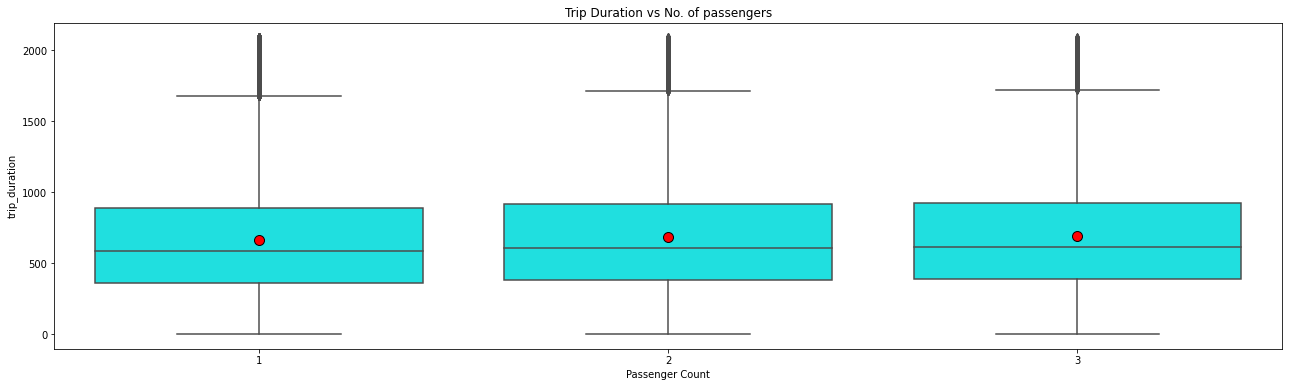

In [ ]:
plt.figure(figsize=(22, 6))
sns.boxplot(x = taxi_df['passenger_count'], y = taxi_df['trip_duration'], color = 'cyan', showmeans=True, meanprops={"marker":"o", "markerfacecolor":"Red", "markeredgecolor":"black","markersize":"10"})
plt.xlabel('Passenger Count')
plt.title ("Trip Duration vs No. of passengers");

Box plot shows no significant variation means of between passenger counts.

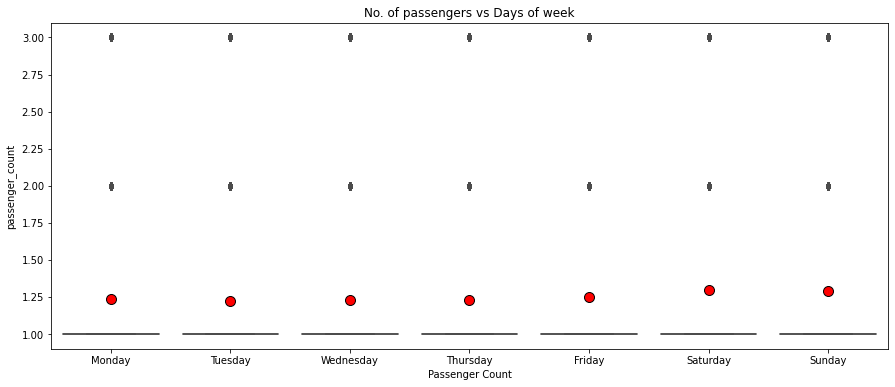

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(x = taxi_df['pickup_weekday'], order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            y = taxi_df['passenger_count'], color = 'cyan', showmeans=True, meanprops={"marker":"o", "markerfacecolor":"Red", "markeredgecolor":"black","markersize":"10"})
plt.xlabel('Passenger Count')
plt.title ("No. of passengers vs Days of week");

No significant variation of means between days of week also.

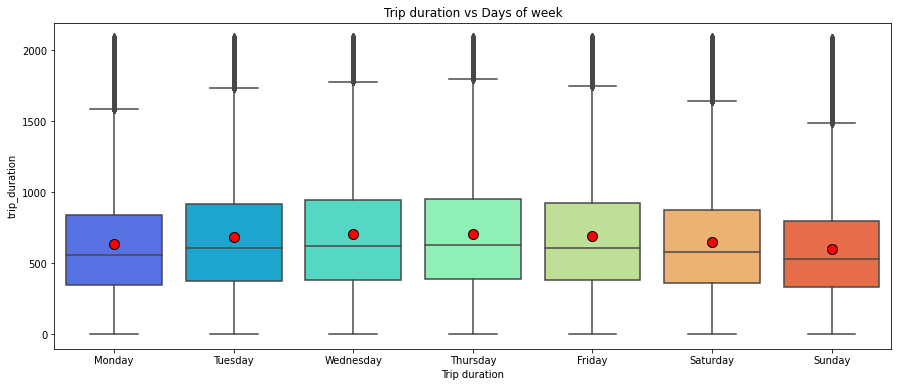

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(x = taxi_df['pickup_weekday'], order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            y = taxi_df['trip_duration'], palette = 'rainbow', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"Red", "markeredgecolor":"black", "markersize":"10"})
plt.xlabel('Trip duration')
plt.title ("Trip duration vs Days of week");

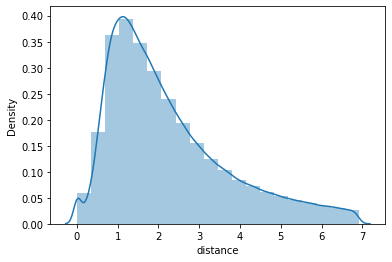

In [ ]:
sns.distplot(taxi_df['distance'], bins = 20);

In [ ]:
print("Median  ", taxi_df['distance'].median())
taxi_df['distance'].describe() 

Median   1.8469552093481973


count    1.141859e+06
mean     2.248198e+00
std      1.476420e+00
min      0.000000e+00
25%      1.145328e+00
50%      1.846955e+00
75%      2.993149e+00
max      6.912633e+00
Name: distance, dtype: float64

### Target Exploration with distance

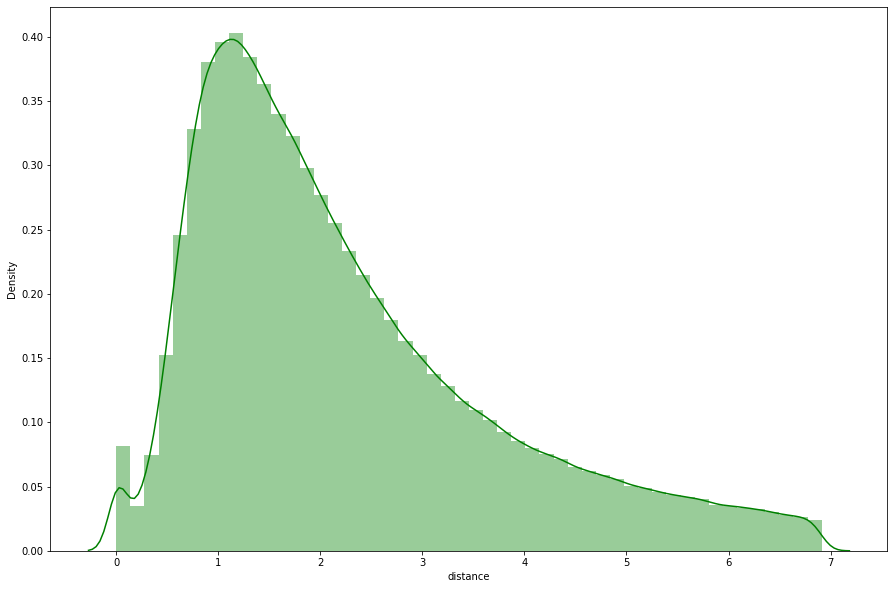

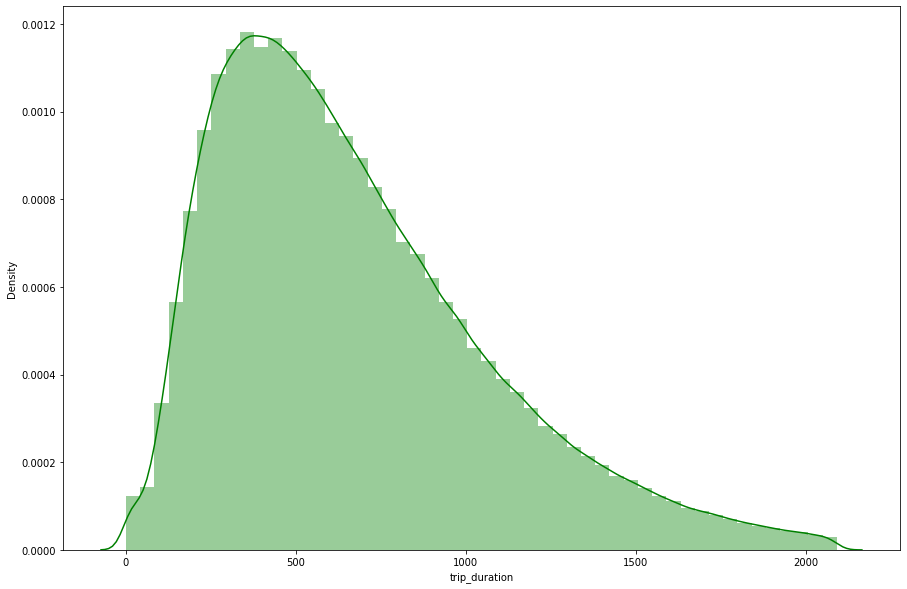

In [ ]:
sample=['distance','trip_duration']
for i in sample:
  plt.figure(figsize=(15,10))
  sns.distplot(taxi_df[i],color="g")

### Lattitude & Longitude

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

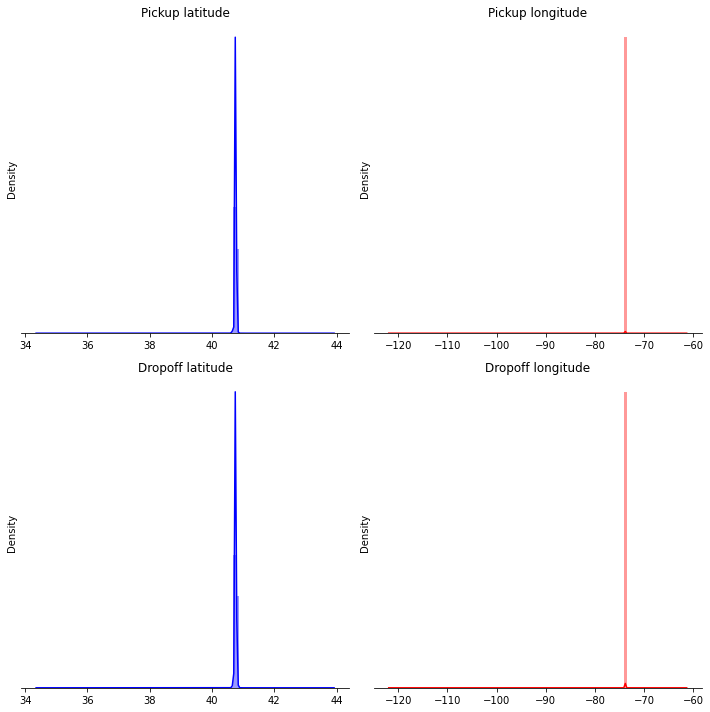

In [ ]:
f, axes = plt.subplots(2,2,figsize=(10, 10))
sns.despine(left=True)
sns.distplot(taxi_df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
axes[0,0].set_title('Pickup latitude')
sns.distplot(taxi_df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
axes[0,1].set_title('Pickup longitude')
sns.distplot(taxi_df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1,0])
axes[1,0].set_title('Dropoff latitude')
sns.distplot(taxi_df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
axes[1,1].set_title('Dropoff longitude')
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73.
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

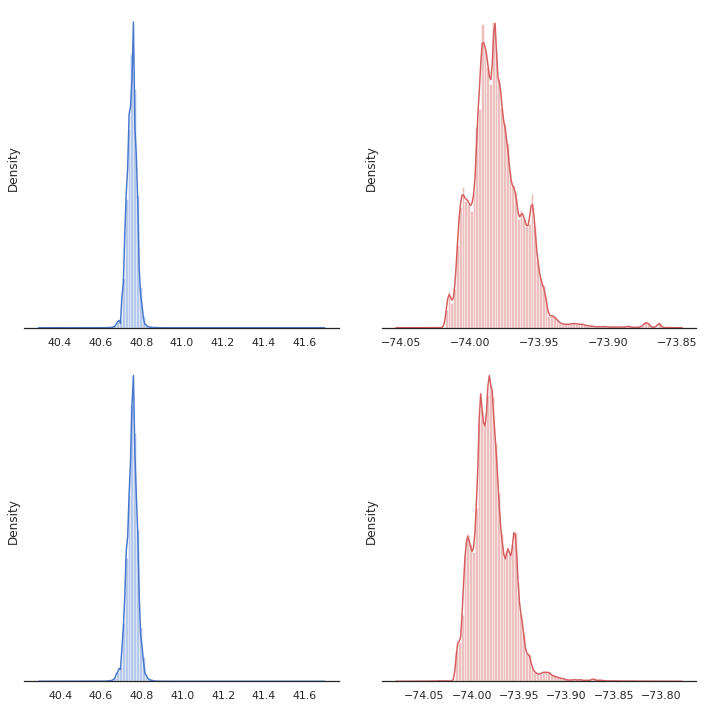

In [ ]:
df = taxi_df.loc[(taxi_df.pickup_latitude > 40.6) & (taxi_df.pickup_latitude < 40.9)]
df = taxi_df.loc[(taxi_df.dropoff_latitude>40.6) & (taxi_df.dropoff_latitude < 40.9)]
df = taxi_df.loc[(taxi_df.dropoff_longitude > -74.05) & (taxi_df.dropoff_longitude < -73.85)]
df = taxi_df.loc[(taxi_df.pickup_longitude > -74.05) & (taxi_df.pickup_longitude < -73.85)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lattitude and longitude only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms.

#### Map Visualisation

The Taxi pickup locations by placing longitude and lattitude marker on the MAP of the US. So that we can analyze below questions:

* Are all pickups constrained to NYC and it's surrounding areas?
* Is there any unusual location of the pickup?
* Are the lattitude longitude constrained to the land area of the US and nowhere else?

(-74.03, -73.75)

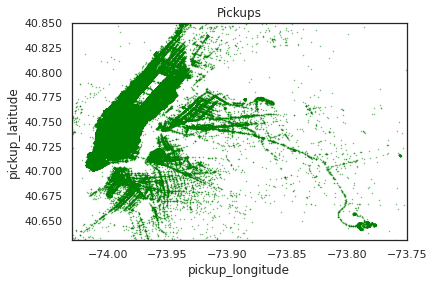

In [ ]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

taxi_df.plot(kind='scatter', x='pickup_longitude',y='pickup_latitude',
          color='green',
          s=0.2, alpha =.6)
plt.title('Pickups')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

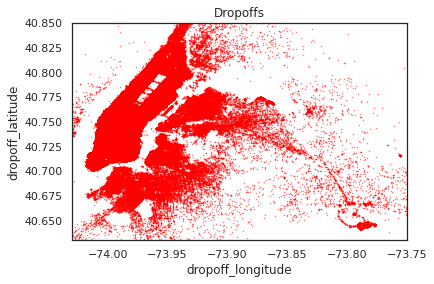

In [ ]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

taxi_df.plot(kind='scatter', x='dropoff_longitude',y='dropoff_latitude',
          color='Red',
          s=0.2, alpha =.6)
plt.title('Dropoffs')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [ ]:
import folium
nyc = folium.Map(location=[40.730610,-73.935242],zoom_start=12, control_scale=True)
for i in taxi_df.index[:100]:
  folium.Marker(location=[taxi_df['pickup_latitude'][i], taxi_df['pickup_longitude'][i]],icon=folium.Icon(color="blue")).add_to(nyc)
nyc

In [ ]:
for i in taxi_df.index[:100]:
  folium.Marker(location=[taxi_df['dropoff_latitude'][i], taxi_df['dropoff_longitude'][i]],icon=folium.Icon(color="red", icon="info-sign")).add_to(nyc)
nyc

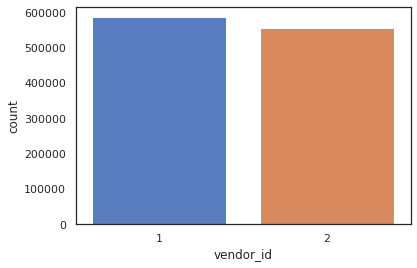

In [ ]:
sns.countplot(x=taxi_df['vendor_id'])

### Observation:

Vendor Id 2 (53%) had slightly more trips than Vendor Id 1(47%). Both had more outliers on Sundays and Mondays (Pickup day 6 and zero respectively). Rides for both exhibit the same pattern with rides increasing from Monday, reaching their peaks on Thursday and then decreasing to reach their lowest number of rides on Sunday.

In [ ]:
#Dummify all the categorical features like "pickup_day" except
taxi_df= pd.get_dummies(taxi_df, columns=["pickup_day"], prefix=['day'])

In [ ]:
num_cols = list(taxi_df.select_dtypes(exclude='object').columns)
cate_cols = list(taxi_df.select_dtypes(include='object').columns)
print("Num cols: ",num_cols)
print("Cate cols: ",cate_cols)

Num cols:  ['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'distance', 'pickup_hour', 'pickup_date', 'pickup_month', 'Peak_Hour', 'trip_duration_hour', 'log_distance', 'log_trip_duration', 'duration_time', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
Cate cols:  ['id', 'pickup_weekday', 'pickup_timezone', 'dropoff_timezone']


In [ ]:
features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',\
            'dropoff_latitude', 'distance', 'pickup_hour', 'pickup_date', 'pickup_month', 'store_and_fwd_flag',\
            'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'Peak_Hour']

In [ ]:
# Data for all the independent variables
X = taxi_df[features]

# Data for the dependent variable
Y = taxi_df['trip_duration']

In [ ]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Check the shape of train dataset
print(X_train.shape,Y_train.shape)

# Check the shape of test dataset
print(X_test.shape, Y_test.shape)

(913487, 19) (913487,)
(228372, 19) (228372,)


In [ ]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'pickup_hour',
       'pickup_date', 'pickup_month', 'store_and_fwd_flag', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'Peak_Hour'],
      dtype='object')

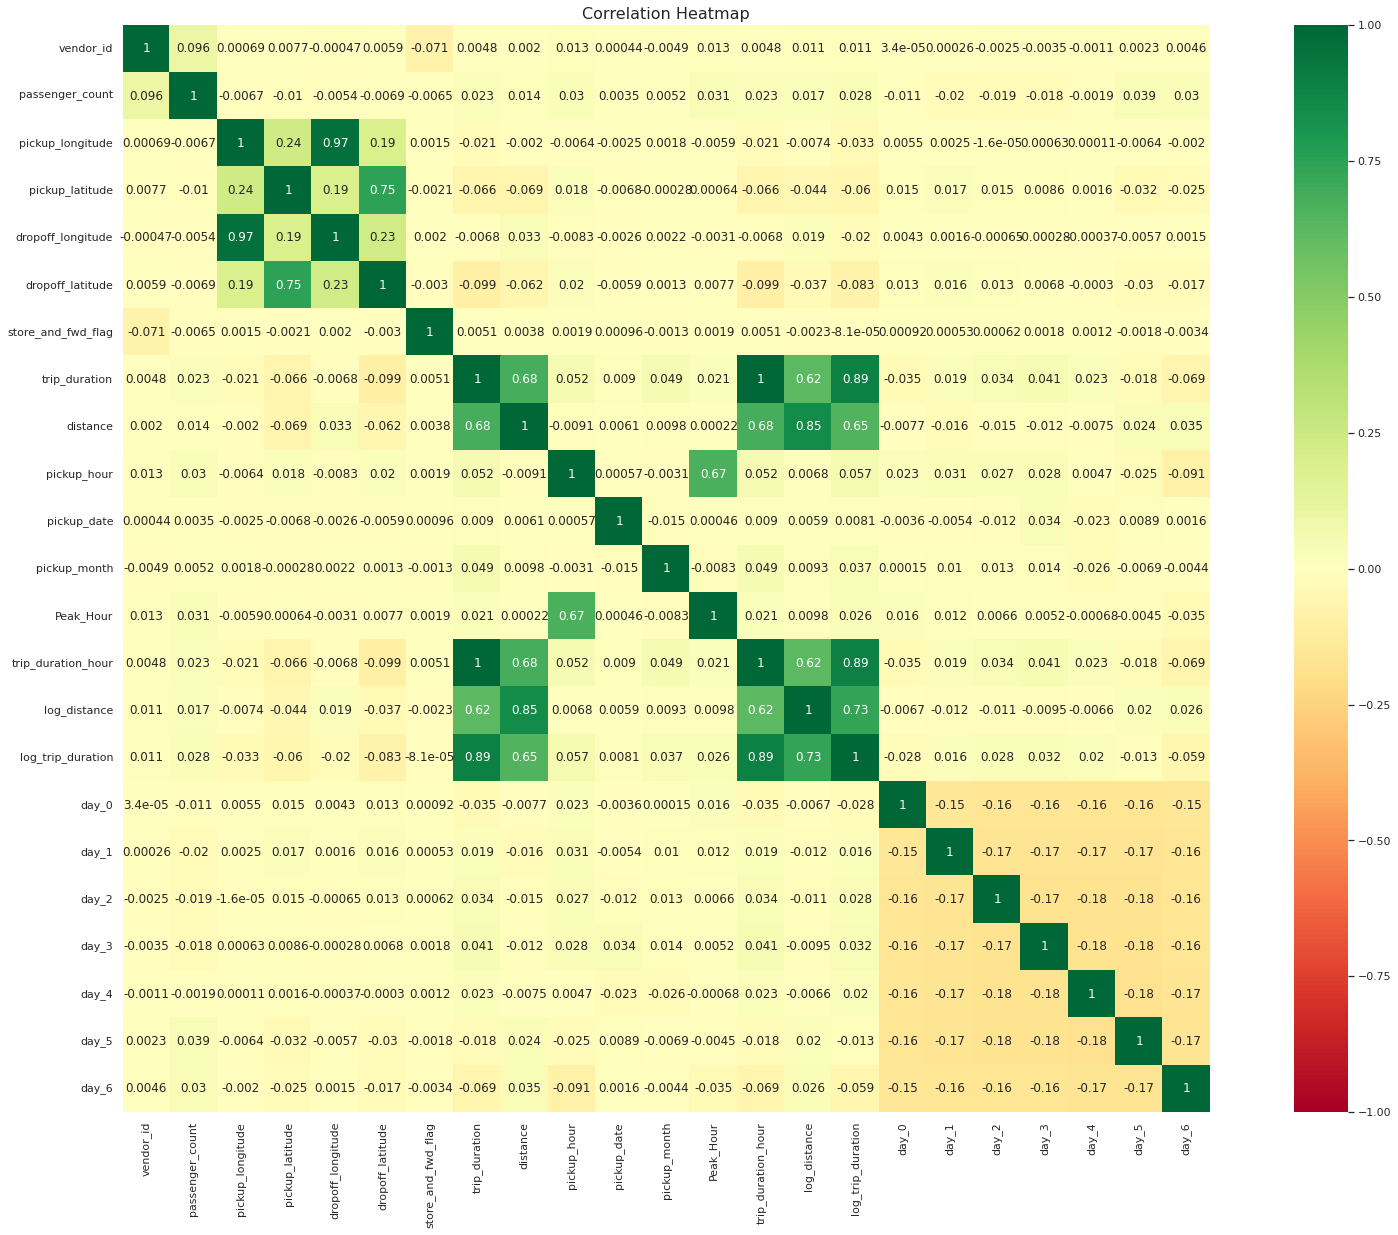

In [ ]:
plt.figure (figsize= (30,20))

sns.heatmap(taxi_df.corr(), cmap='RdYlGn', annot=True,vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [ ]:
from matplotlib import legend
# Function for evaluation metric for regression
def EvaluationMetric(Xt, yt, yp, disp="on"):
  ''' Take the different set of parameter and prints evaluation metrics '''
  MSE = round(mean_squared_error(yt, yp), 4)
  RMSE = (np.sqrt(MSE))
  R2 = (r2_score(y_true=yt, y_pred=yp))
  Adjusted_R2 = (1-(1-r2_score(yt, yp))*((Xt.shape[0]-1)/(Xt.shape[0]-Xt.shape[1]-1)))
  if disp=="on":
    print("MSE :", MSE)
    print("RMSE :", RMSE)
    print("R2 :", R2)
    print("Adjusted R2 :", Adjusted_R2)
  
  #Plotting Actual and Predicted Values
  plt.figure(figsize=(18,6))
  plt.plot((yp)[:100]) 
  plt.plot((np.array(yt)[:100]))
  plt.legend(["Predicted", "Actual"])
  plt.title('Actual and Predicted Time Duration')

  return (MSE, RMSE, R2, Adjusted_R2) 

### Linear Regression

In [ ]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression()

In [ ]:
y_pred_train = regressor.predict(X_train)

In [ ]:
# Predicting the Test set results
y_pred_test = regressor.predict(X_test)

MSE : 81018.6033
RMSE : 284.6376702054737
R2 : 0.4883354567042123
Adjusted R2 : 0.488324814145343


(81018.6033, 284.6376702054737, 0.4883354567042123, 0.488324814145343)

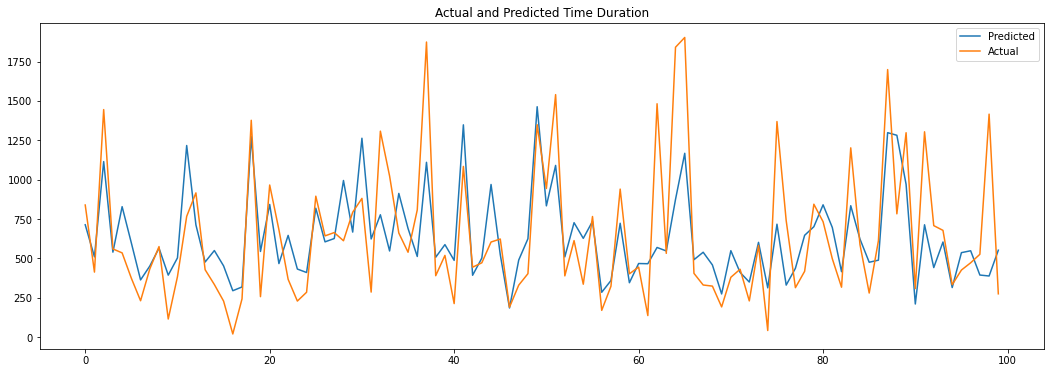

In [ ]:
#Evaluation metrics for Train set
EvaluationMetric(X_train, Y_train, y_pred_train)

MSE : 81277.316
RMSE : 285.0917676819168
R2 : 0.49009704208282723
Adjusted R2 : 0.4900546156700941


(81277.316, 285.0917676819168, 0.49009704208282723, 0.4900546156700941)

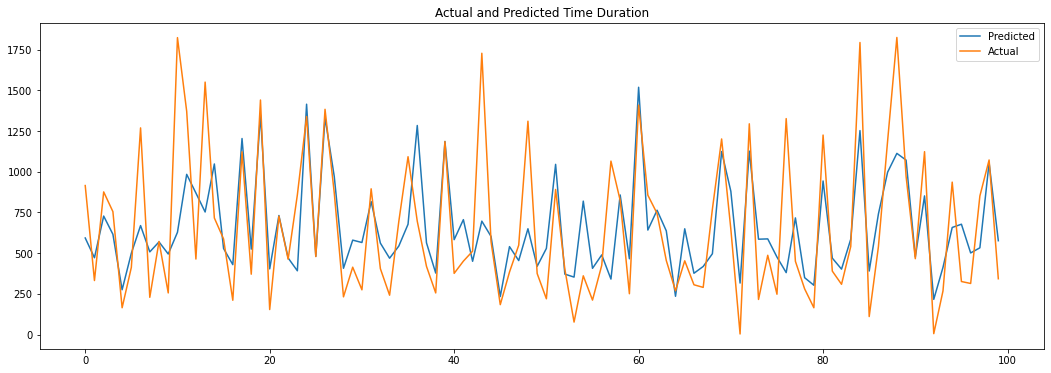

In [ ]:
#Evaluation metrics for Test set
EvaluationMetric(X_test, Y_test, y_pred_test)

### Lasso Regression

In [ ]:
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_regressor.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

In [ ]:
lasso_regressor.score(X_train, Y_train)

0.48833545670421186

In [ ]:
print("The best fit alpha value is found out to be :" , lasso_regressor.best_params_)
print("\nUsing ", lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-15}

Using  {'alpha': 1e-15}  the negative mean squared error is:  0.4879653327338824


In [ ]:
y_pred_lasso = lasso_regressor.predict(X_test)
y_pred_lasso_train = lasso_regressor.predict(X_train)

MSE : 81018.6033
RMSE : 284.6376702054737
R2 : 0.48833545670421186
Adjusted R2 : 0.48832481414534257


(81018.6033, 284.6376702054737, 0.48833545670421186, 0.48832481414534257)

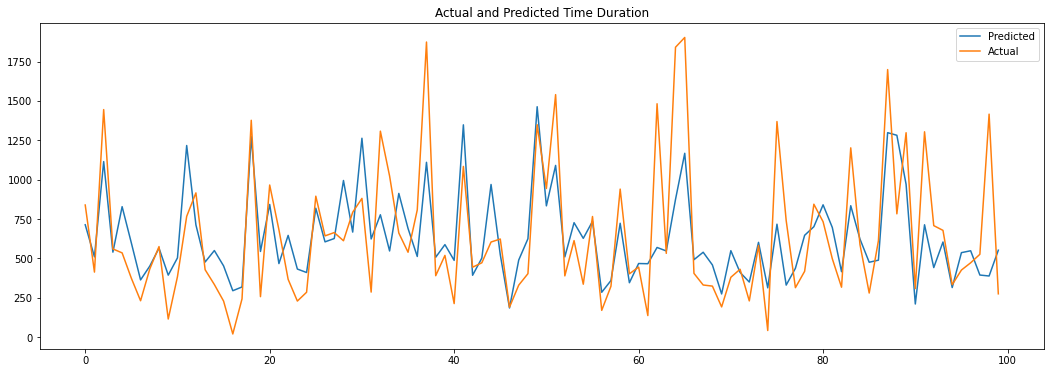

In [ ]:
#Evaluation metrics for Train set
EvaluationMetric(X_train, Y_train, y_pred_lasso_train)

MSE : 81277.316
RMSE : 285.0917676819168
R2 : 0.4900970420828267
Adjusted R2 : 0.49005461567009356


(81277.316, 285.0917676819168, 0.4900970420828267, 0.49005461567009356)

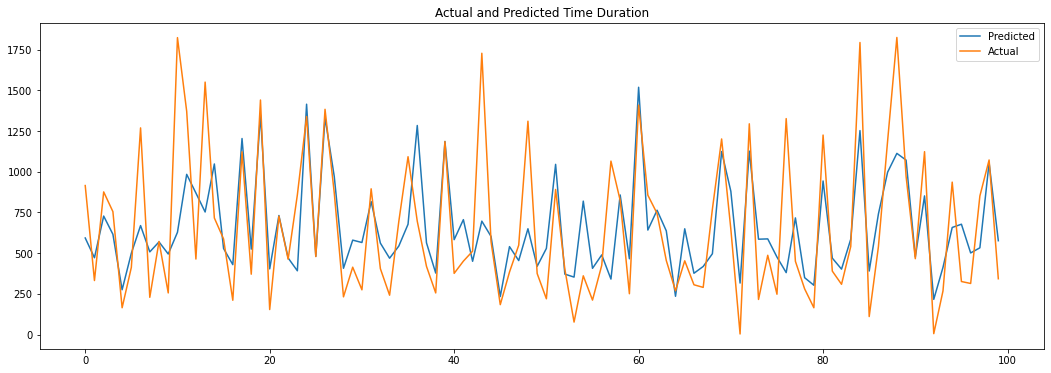

In [ ]:
#Evaluation metrics for Test set
EvaluationMetric(X_test, Y_test, y_pred_lasso)

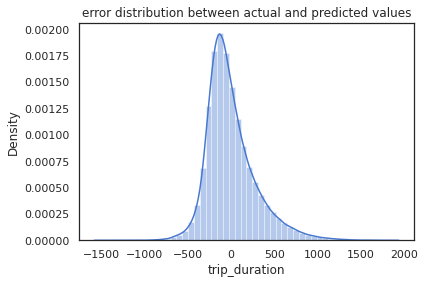

In [ ]:
sns.distplot(Y_test - y_pred_lasso ).set_title("error distribution between actual and predicted values")
plt.show()

### Ridge Regression

In [ ]:
# Cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

In [ ]:
ridge_regressor.score(X_train, Y_train)

0.48833539741215326

In [ ]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}

Using  {'alpha': 1}  the negative mean squared error is:  0.4879653327338824


In [ ]:
y_pred_ridge_test = ridge_regressor.predict(X_test)
y_pred_ridge_train=ridge_regressor.predict(X_train)

MSE : 81018.6127
RMSE : 284.6376867176938
R2 : 0.48833539741215326
Adjusted R2 : 0.48832475485205074


(81018.6127, 284.6376867176938, 0.48833539741215326, 0.48832475485205074)

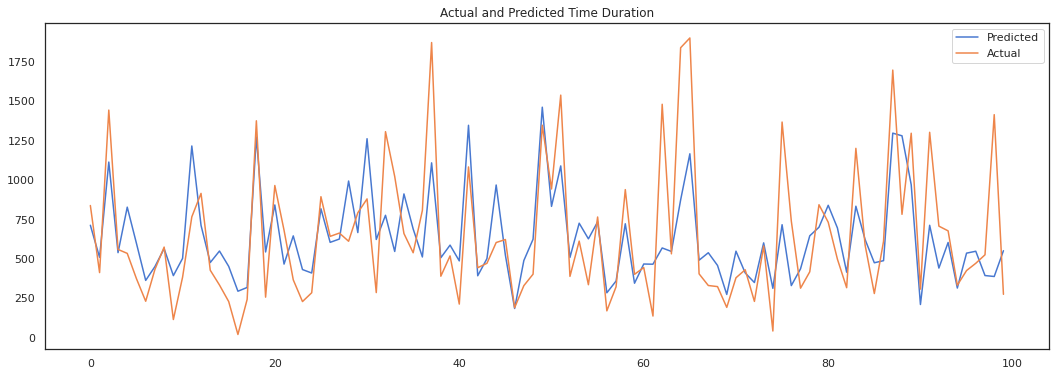

In [ ]:
#Evaluation metrics for Train set
EvaluationMetric(X_train, Y_train, y_pred_ridge_train)

MSE : 81277.4661
RMSE : 285.0920309303647
R2 : 0.49009610060212394
Adjusted R2 : 0.49005367411105505


(81277.4661, 285.0920309303647, 0.49009610060212394, 0.49005367411105505)

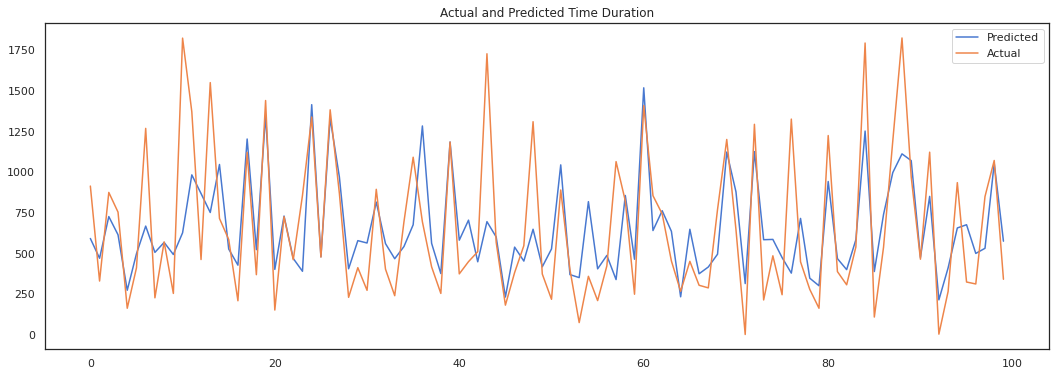

In [ ]:
#Evaluation metrics for Test set
EvaluationMetric(X_test, Y_test, y_pred_ridge_test)

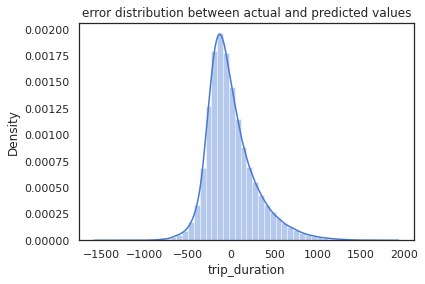

In [ ]:
sns.distplot(Y_test - y_pred_ridge_test ).set_title("error distribution between actual and predicted values")
plt.show()

### XGBoost

In [ ]:
# Number of trees
n_estimators = [50,100,120]

# Maximum depth of trees
max_depth = [5,7,9]
min_samples_split = [40,50]

# HYperparameter Grid
param_xgb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_split':min_samples_split}

In [ ]:
xgb_model = xgb.XGBRegressor()
# Grid search
xgb_grid = GridSearchCV(estimator = xgb_model, param_grid = param_xgb, cv = 3, verbose = 2, scoring = "r2")
xgb_grid.fit(X_train, Y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[07:20:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .max_depth=5, min_samples_split=40, n_estimators=50; total time=  30.5s
[07:20:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .max_depth=5, min_samples_split=40, n_estimators=50; total time=  29.1s
[07:21:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .max_depth=5, min_samples_split=40, n_estimators=50; total time=  29.1s
[07:21:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END max_depth=5, min_samples_split=40, n_estimators=100; total time=  58.5s
[07:22:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor o

GridSearchCV(cv=3, estimator=XGBRegressor(),
             param_grid={'max_depth': [5, 7, 9], 'min_samples_split': [40, 50],
                         'n_estimators': [50, 100, 120]},
             scoring='r2', verbose=2)

In [ ]:
xgb_grid.best_score_

0.7264758070848534

In [ ]:
xgb_grid.best_params_

{'max_depth': 9, 'min_samples_split': 40, 'n_estimators': 120}

In [ ]:
xgb_optimal_model =xgb_grid.best_estimator_

In [ ]:
y_pred_xgb_test = xgb_optimal_model.predict(X_test)
y_pred_xgb_train = xgb_optimal_model.predict(X_train)

MSE : 39624.7195
RMSE : 199.05958781229302
R2 : 0.7497542147168954
Adjusted R2 : 0.7497490096356825


(39624.7195, 199.05958781229302, 0.7497542147168954, 0.7497490096356825)

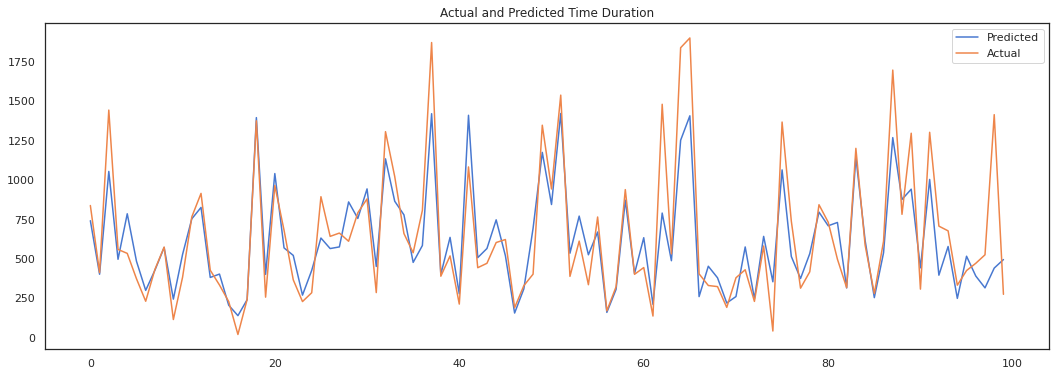

In [ ]:
#Evaluation metrics for Train set
EvaluationMetric(X_train, Y_train, y_pred_xgb_train)

MSE : 42987.8545
RMSE : 207.33512606406083
R2 : 0.7303105558760847
Adjusted R2 : 0.730288116399144


(42987.8545, 207.33512606406083, 0.7303105558760847, 0.730288116399144)

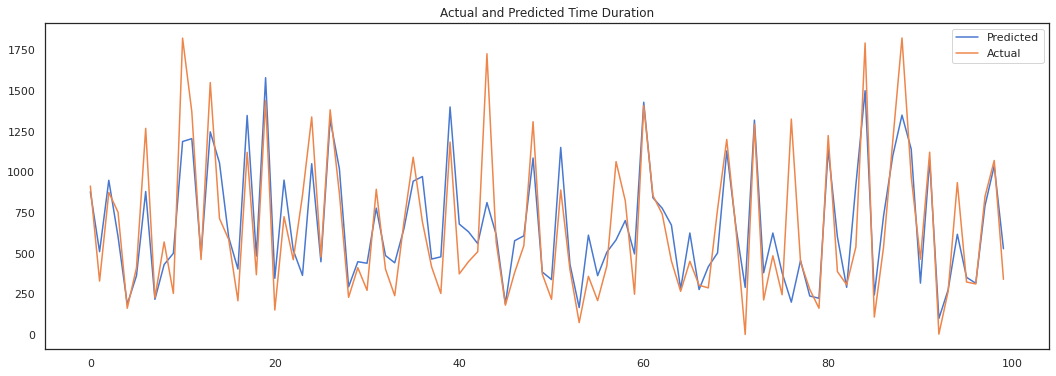

In [ ]:
#Evaluation metrics for Test set
EvaluationMetric(X_test, Y_test, y_pred_xgb_test)

In [ ]:
xgb_optimal_model.feature_importances_

array([0.00928314, 0.00356554, 0.01528147, 0.01429975, 0.01804238,
       0.03205497, 0.4849212 , 0.07281806, 0.01189279, 0.02386873,
       0.00212623, 0.05618048, 0.02166273, 0.02049595, 0.02495911,
       0.01983913, 0.06909416, 0.09166487, 0.00794933], dtype=float32)

In [ ]:
importances = xgb_optimal_model.feature_importances_
importance_dict = {'Feature' : list(X_train.columns), 'Feature Importance' : importances}
importance_df = pd.DataFrame(importance_dict)
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
6,distance,0.484921
17,day_6,0.091665
7,pickup_hour,0.072818
16,day_5,0.069094
11,day_0,0.056180
5,dropoff_latitude,0.032055
14,day_3,0.024959
9,pickup_month,0.023869
12,day_1,0.021663
13,day_2,0.020496


### Gradient Boosting

In [ ]:
# Number of trees
n_estimators = [50,70]

# Maximum depth of trees
max_depth = [3,5,7]

# Minimum number of samples required to split a node
min_samples_split = [50,70]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Grid
param_gb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
# Create an instance of the  GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor()

# Grid search
gb_grid = GridSearchCV(estimator=gb_model, param_grid = param_gb, cv = 3, verbose=2, scoring='r2')
gb_grid.fit(X_train, Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=3, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time= 1.9min
[CV] END max_depth=3, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time= 1.9min
[CV] END max_depth=3, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time= 1.8min
[CV] END max_depth=3, min_samples_leaf=40, min_samples_split=50, n_estimators=70; total time= 2.5min
[CV] END max_depth=3, min_samples_leaf=40, min_samples_split=50, n_estimators=70; total time= 2.5min
[CV] END max_depth=3, min_samples_leaf=40, min_samples_split=50, n_estimators=70; total time= 2.5min
[CV] END max_depth=3, min_samples_leaf=40, min_samples_split=70, n_estimators=50; total time= 1.8min
[CV] END max_depth=3, min_samples_leaf=40, min_samples_split=70, n_estimators=50; total time= 1.8min
[CV] END max_depth=3, min_samples_leaf=40, min_samples_split=70, n_estimators=50; total time= 1.8min
[CV] END max_depth=3, min_samp

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 70],
                         'n_estimators': [50, 70]},
             scoring='r2', verbose=2)

In [ ]:
gb_grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 40,
 'min_samples_split': 70,
 'n_estimators': 70}

In [ ]:
gb_grid.best_estimator_

GradientBoostingRegressor(max_depth=7, min_samples_leaf=40,
                          min_samples_split=70, n_estimators=70)

In [ ]:
gb_optimal_model = gb_grid.best_estimator_

In [ ]:
y_preds_gb = gb_optimal_model.predict(X_test)
y_pred_gb_train = gb_optimal_model.predict(X_train)

MSE : 49163.237
RMSE : 221.72784443998006
R2 : 0.6895147016164425
Adjusted R2 : 0.6895082435608484


(49163.237, 221.72784443998006, 0.6895147016164425, 0.6895082435608484)

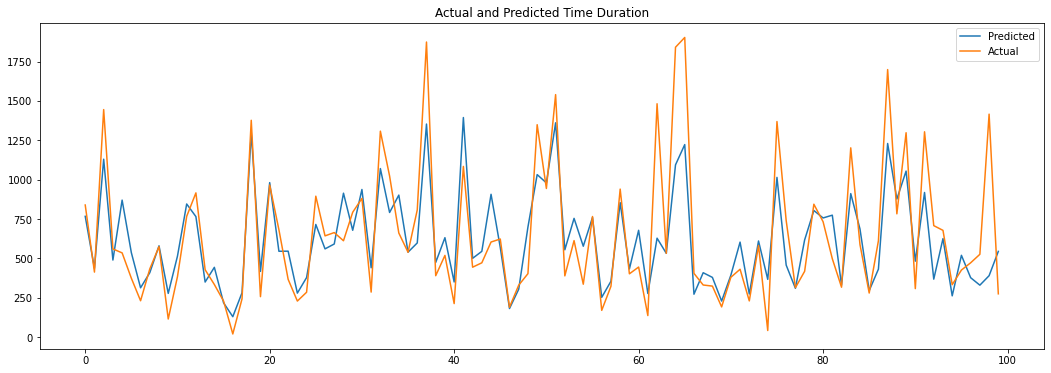

In [ ]:
#Evaluation metrics for Train set
EvaluationMetric(X_train, Y_train, y_pred_gb_train)

MSE : 49915.7648
RMSE : 223.4183627189135
R2 : 0.6868474825189698
Adjusted R2 : 0.6868214267023702


(49915.7648, 223.4183627189135, 0.6868474825189698, 0.6868214267023702)

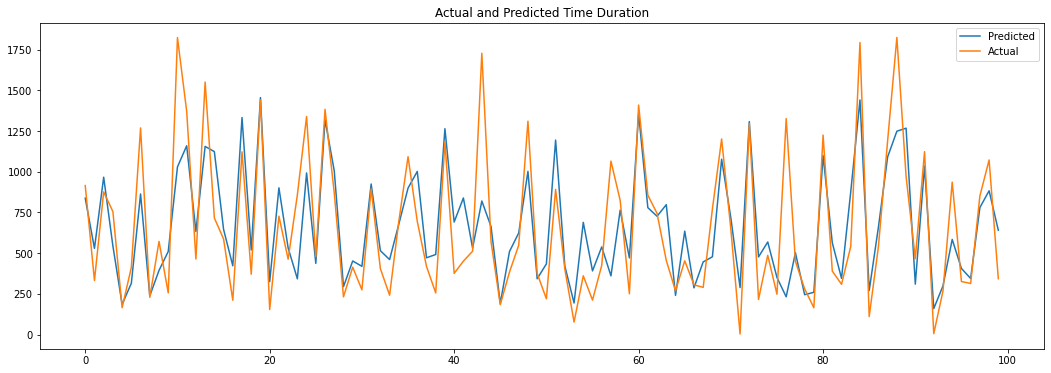

In [ ]:
#Evaluation metrics for Test set
EvaluationMetric(X_test, Y_test, y_preds_gb)

In [ ]:
gb_optimal_model.feature_importances_

array([1.28811871e-03, 2.89679087e-04, 2.50167623e-02, 1.85289082e-02,
       2.38253664e-02, 5.98018107e-02, 7.11244634e-01, 1.03375486e-01,
       4.70220725e-03, 6.67238903e-03, 0.00000000e+00, 4.70855165e-03,
       1.24574967e-03, 8.96309058e-04, 1.01317280e-03, 1.18318759e-03,
       1.55693942e-02, 1.95820989e-02, 1.05617456e-03])

In [ ]:
importances = gb_optimal_model.feature_importances_
importance_dict = {'Feature' : list(X_train.columns), 'Feature Importance' : importances}
importance_df = pd.DataFrame(importance_dict)
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
6,distance,0.711245
7,pickup_hour,0.103375
5,dropoff_latitude,0.059802
2,pickup_longitude,0.025017
4,dropoff_longitude,0.023825
17,day_6,0.019582
3,pickup_latitude,0.018529
16,day_5,0.015569
9,pickup_month,0.006672
11,day_0,0.004709


### Light GBM

In [ ]:
from lightgbm import LGBMRegressor
# Applying LightGBM
n_estimator = [5,10,20] # No. of tree
max_depth = [5,7,9] # max depth of tree
min_samples_split = [40,50]
params = {"n_estimator":n_estimator,"max_depth":max_depth,"min_samples_split":min_samples_split}
lgb = LGBMRegressor()
gs_lgb = GridSearchCV(lgb,params,cv=3,verbose=2,scoring='r2')
gs_lgb.fit(X_train, Y_train)
print(gs_lgb.best_score_)
print(gs_lgb.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...max_depth=5, min_samples_split=40, n_estimator=5; total time=   6.2s
[CV] END ...max_depth=5, min_samples_split=40, n_estimator=5; total time=   6.2s
[CV] END ...max_depth=5, min_samples_split=40, n_estimator=5; total time=   6.2s
[CV] END ..max_depth=5, min_samples_split=40, n_estimator=10; total time=   6.2s
[CV] END ..max_depth=5, min_samples_split=40, n_estimator=10; total time=   7.7s
[CV] END ..max_depth=5, min_samples_split=40, n_estimator=10; total time=   6.2s
[CV] END ..max_depth=5, min_samples_split=40, n_estimator=20; total time=   6.2s
[CV] END ..max_depth=5, min_samples_split=40, n_estimator=20; total time=   6.2s
[CV] END ..max_depth=5, min_samples_split=40, n_estimator=20; total time=   6.2s
[CV] END ...max_depth=5, min_samples_split=50, n_estimator=5; total time=   6.2s
[CV] END ...max_depth=5, min_samples_split=50, n_estimator=5; total time=   6.2s
[CV] END ...max_depth=5, min_samples_split=50, n

In [ ]:
gs_lgb.best_estimator_

LGBMRegressor(max_depth=9, min_samples_split=40, n_estimator=5)

In [ ]:
gs_lgb_opt_model = gs_lgb.best_estimator_

In [ ]:
y_preds_lgb = gs_lgb_opt_model.predict(X_test)
y_pred_lgb_train = gs_lgb_opt_model.predict(X_train)

MSE : 49837.8321
RMSE : 223.24388479866587
R2 : 0.6852543666188147
Adjusted R2 : 0.6852478199487825


(49837.8321, 223.24388479866587, 0.6852543666188147, 0.6852478199487825)

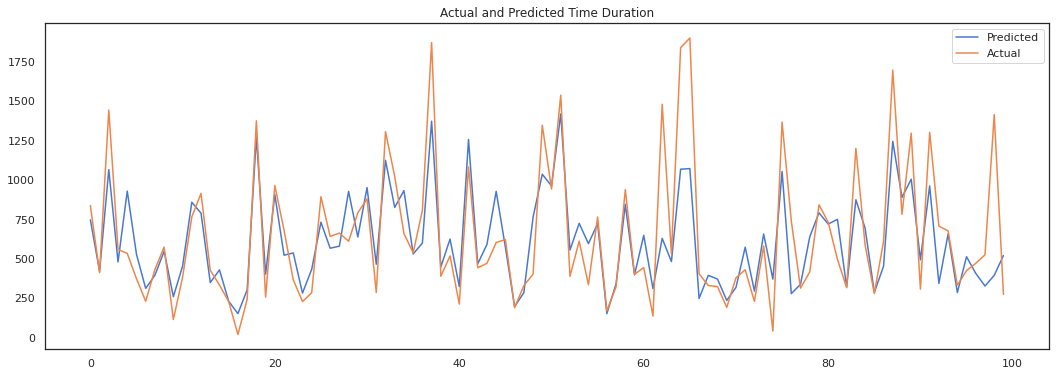

In [ ]:
#Evaluation metrics for Train set
EvaluationMetric(X_train, Y_train, y_pred_lgb_train)

MSE : 50084.4809
RMSE : 223.79562305818226
R2 : 0.685789021903241
Adjusted R2 : 0.6857628780175564


(50084.4809, 223.79562305818226, 0.685789021903241, 0.6857628780175564)

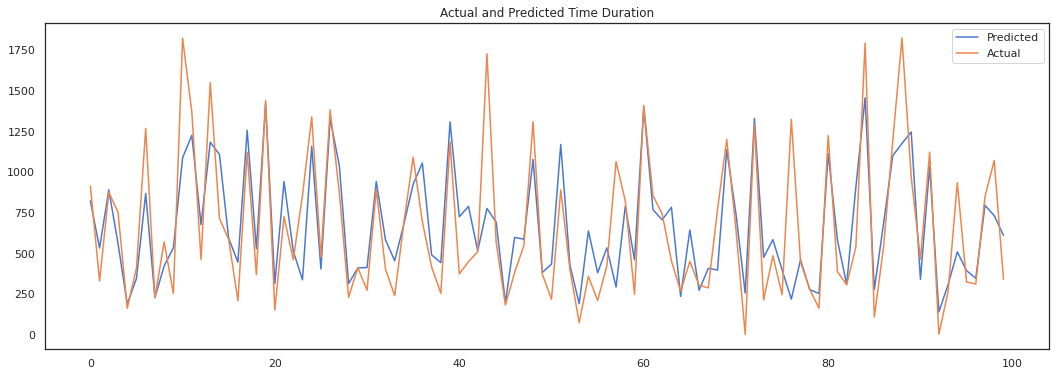

In [ ]:
#Evaluation metrics for Test set
EvaluationMetric(X_test, Y_test, y_preds_lgb)

In [ ]:
importances = gs_lgb_opt_model.feature_importances_
importance_dict = {'Feature' : list(X_train.columns), 'Feature Importance' : importances}
importance_df = pd.DataFrame(importance_dict)
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
7,pickup_hour,530
5,dropoff_latitude,470
2,pickup_longitude,360
4,dropoff_longitude,360
6,distance,328
3,pickup_latitude,292
16,day_5,128
8,pickup_date,115
17,day_6,111
9,pickup_month,108


### Model Comparison

In [ ]:
# Training Set
from prettytable import PrettyTable
train = PrettyTable(['SL NO',"MODEL_NAME", "Train MSE", "Train RMSE",'Train R^2','Train Adjusted R^2'])
train.add_row(['1','Linear Regression','81018.6033', '284.6376702054737', '0.4883354567042123','0.488324814145343'])
train.add_row(['2','Lasso Regression','81018.6033','284.6376702054737','0.48833545670421186','0.48832481414534257'])
train.add_row(['3','Ridge Regression ','81018.6127','284.6376867176938','0.48833539741215326','0.48832475485205074'])
train.add_row(['4','XGBRegressor','39624.7195','199.05958781229302','0.7497542147168954','0.7497490096356825'])
train.add_row(['5','GradientBoosting','49163.237','221.72784443998006','0.6895147016164425','0.6895082435608484'])
train.add_row(['6','LightGBM','49837.8321','223.24388479866587','0.6852543666188147','0.6852478199487825'])
print(train)

+-------+-------------------+------------+--------------------+---------------------+---------------------+
| SL NO |     MODEL_NAME    | Train MSE  |     Train RMSE     |      Train R^2      |  Train Adjusted R^2 |
+-------+-------------------+------------+--------------------+---------------------+---------------------+
|   1   | Linear Regression | 81018.6033 | 284.6376702054737  |  0.4883354567042123 |  0.488324814145343  |
|   2   |  Lasso Regression | 81018.6033 | 284.6376702054737  | 0.48833545670421186 | 0.48832481414534257 |
|   3   | Ridge Regression  | 81018.6127 | 284.6376867176938  | 0.48833539741215326 | 0.48832475485205074 |
|   4   |    XGBRegressor   | 39624.7195 | 199.05958781229302 |  0.7497542147168954 |  0.7497490096356825 |
|   5   |  GradientBoosting | 49163.237  | 221.72784443998006 |  0.6895147016164425 |  0.6895082435608484 |
|   6   |      LightGBM     | 49837.8321 | 223.24388479866587 |  0.6852543666188147 |  0.6852478199487825 |
+-------+-------------------

In [ ]:
# Test Set
test = PrettyTable(['SL NO',"MODEL_NAME", "Test MSE", "Test RMSE",'Test R^2','Test Adjusted R^2'])
test.add_row(['1','Linear Regression','81277.316','285.0917676819168','0.49009704208282723','0.490054615670094'])
test.add_row(['2','Lasso Regression','81277.316','285.0917676819168','0.4900970420828267','0.49005461567009356'])
test.add_row(['3','Ridge Regression ','81277.4661','285.0920309303647','0.49009610060212394','0.49005367411105505'])
test.add_row(['4','XGBRegressor','42987.8545','207.33512606406083','0.7303105558760847','0.730288116399144'])
test.add_row(['5','GradientBoosting','49915.7648','223.4183627189135','0.6868474825189698','0.6868214267023702'])
test.add_row(['6','LightGBM','50084.4809','223.79562305818226','0.685789021903241','0.6857628780175564'])
print(test)

+-------+-------------------+------------+--------------------+---------------------+---------------------+
| SL NO |     MODEL_NAME    |  Test MSE  |     Test RMSE      |       Test R^2      |  Test Adjusted R^2  |
+-------+-------------------+------------+--------------------+---------------------+---------------------+
|   1   | Linear Regression | 81277.316  | 285.0917676819168  | 0.49009704208282723 |  0.490054615670094  |
|   2   |  Lasso Regression | 81277.316  | 285.0917676819168  |  0.4900970420828267 | 0.49005461567009356 |
|   3   | Ridge Regression  | 81277.4661 | 285.0920309303647  | 0.49009610060212394 | 0.49005367411105505 |
|   4   |    XGBRegressor   | 42987.8545 | 207.33512606406083 |  0.7303105558760847 |  0.730288116399144  |
|   5   |  GradientBoosting | 49915.7648 | 223.4183627189135  |  0.6868474825189698 |  0.6868214267023702 |
|   6   |      LightGBM     | 50084.4809 | 223.79562305818226 |  0.685789021903241  |  0.6857628780175564 |
+-------+-------------------